
=== Classification Report - Delay Category ===
                   precision    recall  f1-score   support

TECHNICAL_FAILURE       1.00      1.00      1.00        10
       CREW_DELAY       1.00      1.00      1.00        11
          WEATHER       1.00      1.00      1.00         8
  ATC_RESTRICTION       1.00      1.00      1.00        11
  LOGISTICS_ISSUE       1.00      1.00      1.00         9
         SECURITY       1.00      1.00      1.00        11

         accuracy                           1.00        60
        macro avg       1.00      1.00      1.00        60
     weighted avg       1.00      1.00      1.00        60



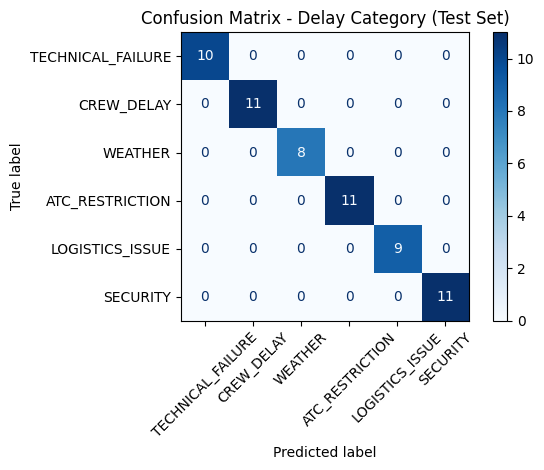


=== Classification Report - Phase Prediction ===
               precision    recall  f1-score   support

     boarding       1.00      1.00      1.00        11
pre-departure       1.00      1.00      1.00        11
     pushback       1.00      1.00      1.00         9
  final check       1.00      1.00      1.00        10
     taxi-out       1.00      1.00      1.00        11
 engine start       1.00      1.00      1.00         8

     accuracy                           1.00        60
    macro avg       1.00      1.00      1.00        60
 weighted avg       1.00      1.00      1.00        60



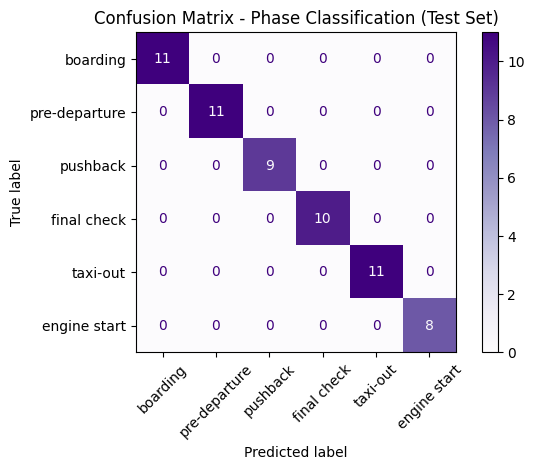

In [13]:
# Aircraft Delay Log - Inference & Evaluation on True Test Set

import torch
import pandas as pd
import warnings
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# === Load true test sets ===
df_label = pd.read_csv("../data/test_split.csv")
df_phase = pd.read_csv("../data/test_phase_split.csv")

# === Load label map ===
label_map = {
    0: "TECHNICAL_FAILURE",
    1: "CREW_DELAY",
    2: "WEATHER",
    3: "ATC_RESTRICTION",
    4: "LOGISTICS_ISSUE",
    5: "SECURITY"
}
reverse_label_map = {v: k for k, v in label_map.items()}

# === Load phase map ===
with open("../model/phase_map.json") as f:
    raw_phase_map = json.load(f)
phase_map = {v: k for k, v in raw_phase_map.items()}
reverse_phase_map = raw_phase_map

# === Load models and tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("../model/delay_phase_classifier")
label_model = AutoModelForSequenceClassification.from_pretrained("../model/delay_classifier")
phase_model = AutoModelForSequenceClassification.from_pretrained("../model/delay_phase_classifier")
label_model.eval()
phase_model.eval()

# === Inference functions ===
def batch_predict(model, texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).tolist()
    return preds

# === Delay Category Evaluation ===
y_true_label = df_label["label"].map(reverse_label_map).tolist()
y_pred_label = batch_predict(label_model, df_label["log_text"].tolist())

print("\n=== Classification Report - Delay Category ===")
print(classification_report(y_true_label, y_pred_label, target_names=list(label_map.values())))

cm = confusion_matrix(y_true_label, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - Delay Category (Test Set)")
plt.tight_layout()
plt.show()

# === Phase Prediction Evaluation ===
y_true_phase = df_phase["phase"].map(reverse_phase_map).tolist()
y_pred_phase = batch_predict(phase_model, df_phase["log_text"].tolist())


print("\n=== Classification Report - Phase Prediction ===")
print(classification_report(y_true_phase, y_pred_phase, target_names=list(phase_map.values())))

cm_phase = confusion_matrix(y_true_phase, y_pred_phase)
disp_phase = ConfusionMatrixDisplay(confusion_matrix=cm_phase, display_labels=list(phase_map.values()))
disp_phase.plot(xticks_rotation=45, cmap="Purples")
plt.title("Confusion Matrix - Phase Classification (Test Set)")
plt.tight_layout()
plt.show()
